In [12]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from normalization import Normalizer
from algorithmsdp import AlgorithmDP


In [11]:
titanic_data=pd.read_csv('Titanic-Dataset.csv')
titanic_data.head()

titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
# Definir características y variable objetivo
X = titanic_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = titanic_data['Survived']

# Definir los transformadores para características numéricas y categóricas
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el preprocesador para combinar los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un Pipeline con el preprocesador y el clasificador
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Realizar la validación cruzada con 5 pliegues
cv_results = cross_val_score(pipeline, X, y, cv=100, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print(f'Cross-Validation Accuracies: {cv_results}')
print(f'Mean Accuracy: {np.mean(cv_results)}')

Cross-Validation Accuracies: [0.77777778 0.55555556 0.77777778 0.66666667 0.77777778 0.88888889
 1.         1.         0.88888889 0.77777778 0.77777778 0.55555556
 1.         0.88888889 0.55555556 0.66666667 0.88888889 0.77777778
 0.66666667 0.88888889 0.88888889 0.77777778 0.88888889 0.77777778
 0.88888889 0.66666667 0.66666667 0.77777778 0.77777778 1.
 0.77777778 0.77777778 0.88888889 0.66666667 0.77777778 0.88888889
 0.77777778 0.88888889 0.77777778 0.88888889 1.         1.
 0.88888889 0.88888889 0.88888889 0.88888889 1.         1.
 1.         1.         0.88888889 0.55555556 0.66666667 0.77777778
 0.88888889 0.77777778 0.88888889 0.77777778 0.88888889 0.66666667
 0.77777778 0.66666667 0.88888889 0.88888889 1.         0.55555556
 0.66666667 0.66666667 1.         0.77777778 0.77777778 0.77777778
 1.         0.77777778 0.77777778 0.66666667 0.55555556 0.77777778
 0.77777778 0.55555556 0.88888889 0.66666667 1.         0.77777778
 0.66666667 0.77777778 0.88888889 1.         1.         0

### Local Privacy

In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Piecewise Mechanism for Numeric Data
def piecewise_mechanism(t_i_vector, epsilon):
    t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
    t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
    C = (torch.exp(torch.tensor(epsilon / 2)) + 1) / (torch.exp(torch.tensor(epsilon / 2)) - 1)
    
    def l(t_i):
        return (C + 1) / 2 * t_i - (C - 1) / 2
    
    def r(t_i):
        return l(t_i) + C - 1

    x = torch.rand(t_i_tensor.shape)
    threshold = torch.exp(torch.tensor(epsilon / 2)) / (torch.exp(torch.tensor(epsilon / 2)) + 1)
    
    t_i_star = torch.empty(t_i_tensor.shape, dtype=torch.float32)
    
    for i in range(t_i_tensor.shape[0]):
        l_val = l(t_i_tensor[i])
        r_val = r(t_i_tensor[i])
        
        if x[i] < threshold:
            if l_val >= r_val:
                r_val = l_val + 1e-5
            t_i_star[i] = torch.distributions.Uniform(l_val, r_val).sample()
        else:
            if torch.rand(1) < 0.5:
                if -C >= l_val:
                    l_val = -C + 1e-5
                t_i_star[i] = torch.distributions.Uniform(-C, l_val).sample()
            else:
                if r_val >= C:
                    r_val = C - 1e-5
                t_i_star[i] = torch.distributions.Uniform(r_val, C).sample()

    return t_i_star.numpy()

# PrivacyPreserving class for categorical data
class PrivacyPreserving:
    def __init__(self, df, column, epsilon, seed=None):
        self.df = df.copy()
        self.column = column
        self.epsilon = epsilon
        self.categories = df[column].unique()
        self.category_to_index = {category: i for i, category in enumerate(self.categories)}
        self.index_to_category = {i: category for i, category in enumerate(self.categories)}
        self.d = len(self.categories)
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)
    
    def apply_privacy_method(self, method_name):
        if method_name == "direct_encoding_privacy":
            return self.direct_encoding_privacy()[self.column]
        elif method_name == "optimized_unary_encoding_privacy":
            return self.optimized_unary_encoding_privacy()[self.column]
        elif method_name == "rappor_privacy":
            return self.rappor_privacy()[self.column]
        else:
            raise ValueError(f"Invalid privacy method name: {method_name}")
    
    def direct_encoding_privacy(self):
        def direct_encoding(value, d, epsilon):
            p = np.exp(epsilon) / (np.exp(epsilon) + d - 1)
            q = 1 / (np.exp(epsilon) + d - 1)
            
            probabilities = np.full(d, q)
            probabilities[self.category_to_index[value]] = p
            privatized_index = np.random.choice(d, p=probabilities)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: direct_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def optimized_unary_encoding_privacy(self):
        def optimized_unary_encoding(value, d, epsilon):
            p = 0.5
            q = 1 / (np.exp(epsilon) + 1)
            
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[p, 1 - p])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[q, 1 - q])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: optimized_unary_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def rappor_privacy(self):
        def rappor_encode(value, d, f=0.5):
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[1 - f, f])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[f, 1 - f])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: rappor_encode(x, self.d))
        return df_priv

# Apply local differential privacy to numeric and categorical variables

def apply_numerical_privacy(X, numerical_columns, epsilon):
    for column in numerical_columns:
        X[column] = piecewise_mechanism(X[[column]].values, epsilon)
    return X

def apply_categorical_privacy(X, categorical_columns, epsilon, method_name):
    for column in categorical_columns:
        privacy_preserver = PrivacyPreserving(X, column, epsilon)
        X[column] = privacy_preserver.apply_privacy_method(method_name)
    return X
# Prepare dataset




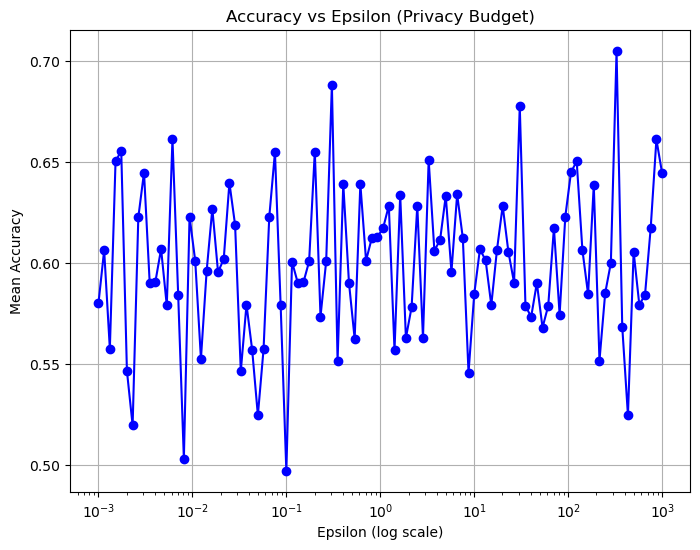

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Assuming the apply_numerical_privacy, apply_categorical_privacy, and PrivacyPreserving are already defined

# Drop rows with missing values to simplify the process
titanic_data = titanic_data.dropna()

# Define features and target
X = titanic_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = titanic_data['Survived']

# Define column transformer for imputing and encoding
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Pipeline with the preprocessor and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Define a list of epsilon values to evaluate (logarithmic scale from 0.1 to 100)
epsilons = np.logspace(-3, 3, 100)
accuracies = []

# Loop through each epsilon value
for epsilon in epsilons:
    # Step 1: Apply privacy-preserving transformations to numerical columns
    X_priv_numerical = apply_numerical_privacy(X.copy(), numerical_features, epsilon)
    
    # Step 2: Apply privacy-preserving transformations to categorical columns
    X_priv_categorical = apply_categorical_privacy(X.copy(), categorical_features, epsilon, 'rappor_privacy')
    
    # Combine numerical and categorical transformations
    X_priv_combined = X_priv_numerical.copy()
    X_priv_combined[categorical_features] = X_priv_categorical[categorical_features]
    
    # Step 3: Apply differential privacy to the target variable (y, 'Survived')
    y_priv_df = pd.DataFrame({'Survived': y})
    y_priv = PrivacyPreserving(y_priv_df, 'Survived', epsilon).apply_privacy_method('rappor_privacy')
    y_priv = y_priv_df['Survived']  # Extract the transformed 'Survived' column after privacy

    # Step 4: Perform cross-validation and calculate accuracy
    cv_results = cross_val_score(pipeline, X_priv_combined, y_priv, cv=5, scoring='accuracy')
    accuracies.append(np.mean(cv_results))

# Step 5: Plot the accuracy for each epsilon
plt.figure(figsize=(8, 6))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy vs Epsilon (Privacy Budget)')
plt.grid(True)
plt.show()
